In [1]:
%tensorflow_version 1.x

from __future__ import print_function

import pickle

import seaborn as sns
import matplotlib.pylab as plt
import PIL
from mpl_toolkits.mplot3d import Axes3D

import pandas as pd
import numpy as np

from sklearn.svm import SVC, LinearSVC
from sklearn.svm import base

from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import keras
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.regularizers import l2
from keras.models import Model
from keras.utils import to_categorical
from keras.applications.vgg19 import VGG19

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.svm.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.svm. Anything that cannot be imported from sklearn.svm is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')
!unrar x drive/My\ Drive/IUST-PR/HW3/data.rar /content

In [17]:
# loading data
batch_size = 64
n_classes = 3
img_size = (224, 224)

datagen = ImageDataGenerator()
train_iterator = datagen.flow_from_directory('data/train/', class_mode='categorical', 
                                             batch_size=batch_size, target_size=img_size, shuffle=True)
# only for NN model
test_iterator = datagen.flow_from_directory('data/test/', class_mode='categorical', 
                                             batch_size=batch_size, target_size=img_size, shuffle=True)

n = 541
x = np.empty((n, img_size[0], img_size[1], n_classes))
y = np.empty((n, n_classes))
for idx in range(len(train_iterator)):
    batchx = train_iterator[idx][0]
    batchy = train_iterator[idx][1]
    if batchx.shape[0] < batch_size:
        x[idx*batch_size:] = batchx
        y[idx*batch_size:] = batchy
    else:
        x[idx*batch_size:(idx+1)*batch_size] = batchx
        y[idx*batch_size:(idx+1)*batch_size] = batchy


n_test = 31
y_test = np.empty((n_test, n_classes))
for idx in range(len(test_iterator)):
    batchy = test_iterator[idx][1]
    if batchx.shape[0] < batch_size:
        y_test[idx*batch_size:] = batchy
    else:
        y_test[idx*batch_size:(idx+1)*batch_size] = batchy


print(x.shape)
print(y.shape)
print(y_test.shape)

Found 541 images belonging to 3 classes.
Found 31 images belonging to 3 classes.
(541, 224, 224, 3)
(541, 3)
(31, 3)


In [18]:
# feature extraction

model = VGG19(include_top=False, weights='imagenet', input_tensor=None, input_shape=(224, 224, 3), classes=1000)
features = model.predict_generator(train_iterator, steps=9)
features_test = model.predict_generator(test_iterator, steps=1)
print('NN data train shape:', features.shape)
print('NN data test shape:', features_test.shape)

NN data train shape: (541, 7, 7, 512)
NN data test shape: (31, 7, 7, 512)


In [33]:
# 2D PCA
pca_2d = PCA(n_components=2)
pca_2d.fit(features.reshape(len(features), -1))
pca_2d_features = pca_2d.transform(features.reshape(len(features), -1))
print(pca_2d_features.shape)

(541, 2)


(165,) (165,) (165,)
(169,) (169,) (169,)
(207,) (207,) (207,)


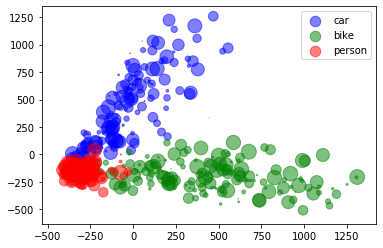

In [6]:
colors = np.argmax(y, axis=1)
fig, ax = plt.subplots()
x_ = pca_2d_features[:,0]
y_ = pca_2d_features[:,1]
legend_ = ['blue', 'green', 'red']
for idx, color in enumerate(['car', 'bike', 'person']):
    area = (15 * np.random.rand(len(x)))**2
    print(x_[colors==idx].shape, y_[colors==idx].shape, colors[colors==idx].shape)
    ax.scatter(x_[colors==idx], y_[colors==idx], s=area, c=legend_[idx], alpha=0.5, label=color)

ax.legend()
plt.show()

In [34]:
# 3D PCA
pca_3d = PCA(n_components=3)
pca_3d.fit(features.reshape(len(features), -1))
pca_3d_features = pca_3d.transform(features.reshape(len(features), -1))
print(pca_3d_features.shape)

(541, 3)


(165,) (165,) (165,)
(169,) (169,) (169,)
(207,) (207,) (207,)


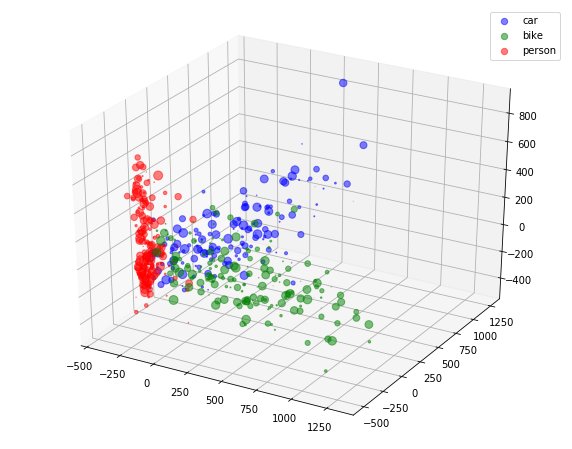

In [35]:
colors = np.argmax(y, axis=1)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
x_ = pca_3d_features[:, 0]
y_ = pca_3d_features[:, 1]
z_ = pca_3d_features[:, 2]
legend_ = ['blue', 'green', 'red']
for idx, color in enumerate(['car', 'bike', 'person']):
    area = (9 * np.random.rand(len(x)))**2
    print(x_[colors==idx].shape, y_[colors==idx].shape, colors[colors==idx].shape)
    ax.scatter(x_[colors==idx], y_[colors==idx], z_[colors==idx], s=area, c=legend_[idx], alpha=0.5, label=color)

ax.legend()
plt.show()

In [38]:
# TSNE 2D
tsne_2d = TSNE(n_components=2, perplexity=30, learning_rate=200)
tsne_2d_features = tsne_2d.fit_transform(features.reshape(len(features), -1))
print(tsne_2d_features.shape)

(541, 2)


(165,) (165,) (165,)
(169,) (169,) (169,)
(207,) (207,) (207,)


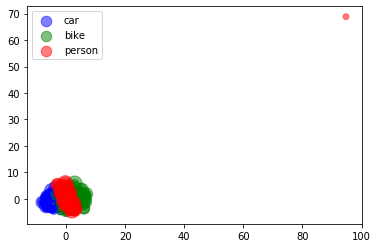

In [40]:
colors = np.argmax(y, axis=1)
fig, ax = plt.subplots()
x_ = tsne_2d_features[:,0]
y_ = tsne_2d_features[:,1]
legend_ = ['blue', 'green', 'red']
for idx, color in enumerate(['car', 'bike', 'person']):
    area = (15 * np.random.rand(len(x)))**2
    print(x_[colors==idx].shape, y_[colors==idx].shape, colors[colors==idx].shape)
    ax.scatter(x_[colors==idx], y_[colors==idx], s=area, c=legend_[idx], alpha=0.5, label=color)

ax.legend()
plt.show()

In [37]:
# TSNE 3D
tsne_3d = TSNE(n_components=3, perplexity=30, learning_rate=200)
tsne_3d_features = tsne_3d.fit_transform(features.reshape(len(features), -1))
print(tsne_3d_features.shape)

(541, 3)


(165,) (165,) (165,)
(169,) (169,) (169,)
(207,) (207,) (207,)


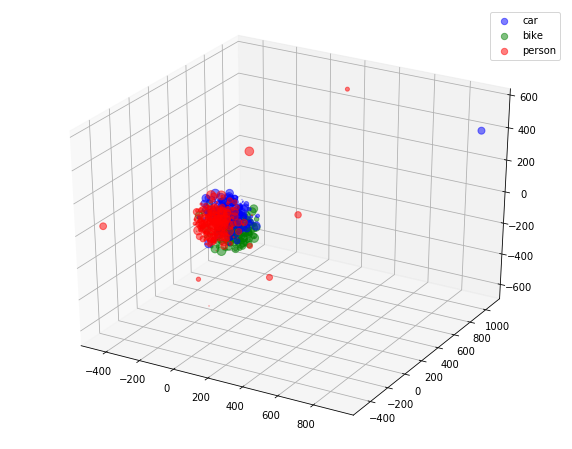

In [39]:
colors = np.argmax(y, axis=1)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
x_ = tsne_3d_features[:, 0]
y_ = tsne_3d_features[:, 1]
z_ = tsne_3d_features[:, 2]
legend_ = ['blue', 'green', 'red']
for idx, color in enumerate(['car', 'bike', 'person']):
    area = (9 * np.random.rand(len(x)))**2
    print(x_[colors==idx].shape, y_[colors==idx].shape, colors[colors==idx].shape)
    ax.scatter(x_[colors==idx], y_[colors==idx], z_[colors==idx], s=area, c=legend_[idx], alpha=0.5, label=color)

ax.legend()
plt.show()

In [41]:
# train test split
from sklearn.model_selection import train_test_split

pca_2d_x_train, pca_2d_x_test, pca_2d_y_train, pca_2d_y_test = train_test_split(pca_2d_features,
                                                                                np.argmax(y, axis=1),
                                                                                test_size=0.1)
pca_3d_x_train, pca_3d_x_test, pca_3d_y_train, pca_3d_y_test = train_test_split(pca_3d_features,
                                                                                np.argmax(y, axis=1),
                                                                                test_size=0.1)
tsne_2d_x_train, tsne_2d_x_test, tsne_2d_y_train, tsne_2d_y_test = train_test_split(tsne_2d_features, 
                                                                                    np.argmax(y, axis=1), 
                                                                                    test_size=0.1)
tsne_3d_x_train, tsne_3d_x_test, tsne_3d_y_train, tsne_3d_y_test = train_test_split(tsne_3d_features, 
                                                                                    np.argmax(y, axis=1), 
                                                                                    test_size=0.1)

print('PCA 2D features train size:',pca_2d_x_train.shape, '------','PCA 2D features test size', pca_2d_x_test.shape)
print('PCA 3D features train size:',pca_3d_x_train.shape, '------','PCA 3D features test size', pca_3d_x_test.shape)
print('TSNE 2D features train size:',tsne_2d_x_train.shape, '------','TSNE 2D features test size', tsne_2d_x_test.shape)
print('TSNE 3D features train size:',tsne_3d_x_train.shape, '------','TSNE 3D features test size', tsne_3d_x_test.shape)

PCA 2D features train size: (486, 2) ------ PCA 2D features test size (55, 2)
PCA 3D features train size: (486, 3) ------ PCA 3D features test size (55, 3)
TSNE 2D features train size: (486, 2) ------ TSNE 2D features test size (55, 2)
TSNE 3D features train size: (486, 3) ------ TSNE 3D features test size (55, 3)


In [0]:
# SVM 

class SVM_MODELS:
    """
    Enum of possible models
    """
    SVC = 1
    LINEAR_SVC = 2


# %% functions
def build_svm(model_type: int, x: np.ndarray, y: np.ndarray, svc_kernel: str = None, save: bool = True,
              path: str = None, **kwargs) -> base:
    """
    Trains a SVM model

    :param model_type: The kernel of SVM model (see `SVM_MODELS` class)
    :param svc_kernel: The possible kernels for `SVC` model (It must be one of ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’)
    It will be ignored if `model_type = LINEAR_SVC`
    :param x: Features in form of numpy ndarray
    :param y: Labels in form of numpy ndarray
    :param save: Whether save trained model on disc or not
    :param path: Path to save fitted model
    :param kwargs: A dictionary of other optional arguments of models in format of {'arg_name': value} (ex: {'C': 2})
    :return:A trained VSM model
    """
    if model_type == SVM_MODELS.SVC:
        model = SVC(kernel=svc_kernel, **kwargs)
    elif model_type == SVM_MODELS.LINEAR_SVC:
        model = LinearSVC(**kwargs)
    else:
        raise Exception('Model {} is not valid'.format(model_type))

    model.fit(x, y)

    if save:
        if path is None:
            path = ''
        pickle.dump(model, open(path + model.__module__ + '.model', 'wb'))
    return model

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


PCA 2D - SVC LINEAR - Test accuracy 0.9090909090909091


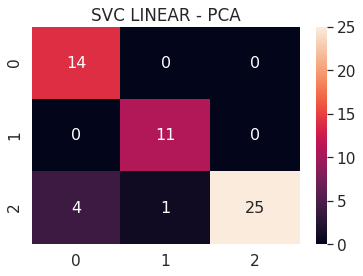

In [43]:
# SVC LINEAR PCA 2D
pca_2d_svc_linear = build_svm(model_type=SVM_MODELS.LINEAR_SVC, x=pca_2d_x_train, y=pca_2d_y_train,
                           max_iter=200000, path='models/pca_2d_', multi_class='ovr')
print('PCA 2D - SVC LINEAR - Test accuracy', pca_2d_svc_linear.score(pca_2d_x_test, pca_2d_y_test))
cm = confusion_matrix(pca_2d_svc_linear.predict(pca_2d_x_test), pca_2d_y_test)
df_cm = pd.DataFrame(cm, range(n_classes), range(n_classes))
sns.set(font_scale=1.4) 
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16})
plt.title('SVC LINEAR - PCA')
plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


PCA 3D - SVC LINEAR - Test accuracy 0.9272727272727272


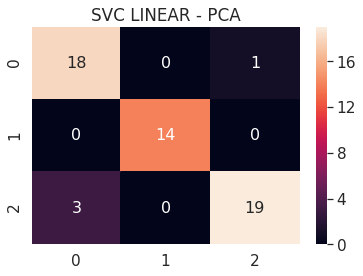

In [44]:
# SVC LINEAR PCA 3D
pca_3d_svc_linear = build_svm(model_type=SVM_MODELS.LINEAR_SVC, x=pca_3d_x_train, y=pca_3d_y_train,
                           max_iter=200000, path='models/pca_3d_', multi_class='ovr')
print('PCA 3D - SVC LINEAR - Test accuracy', pca_3d_svc_linear.score(pca_3d_x_test, pca_3d_y_test))
cm = confusion_matrix(pca_3d_svc_linear.predict(pca_3d_x_test), pca_3d_y_test)
df_cm = pd.DataFrame(cm, range(n_classes), range(n_classes))
sns.set(font_scale=1.4) 
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16})
plt.title('SVC LINEAR - PCA')
plt.show()

PCA 2D - SVC RBF - Test accuracy 0.9090909090909091


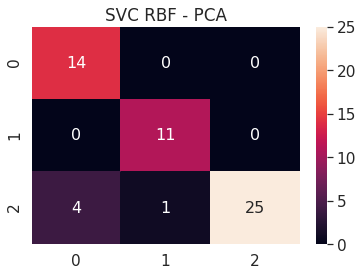

In [45]:
# SVC RBF PCA 2D
pca_2d_svc_rbf = build_svm(model_type=SVM_MODELS.SVC, x=pca_2d_x_train, y=pca_2d_y_train,
                        path='models/pca_2d_', svc_kernel='rbf')

print('PCA 2D - SVC RBF - Test accuracy', pca_2d_svc_rbf.score(pca_2d_x_test, pca_2d_y_test))
cm = confusion_matrix(pca_2d_svc_rbf.predict(pca_2d_x_test), pca_2d_y_test)
df_cm = pd.DataFrame(cm, range(n_classes), range(n_classes))
sns.set(font_scale=1.4) 
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16})
plt.title('SVC RBF - PCA')
plt.show()

PCA 3D - SVC RBF - Test accuracy 0.9272727272727272


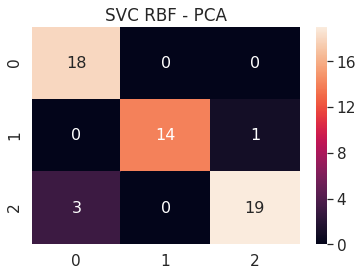

In [46]:
# SVC RBF PCA 3D
pca_3d_svc_rbf = build_svm(model_type=SVM_MODELS.SVC, x=pca_3d_x_train, y=pca_3d_y_train,
                        path='models/pca_3d_', svc_kernel='rbf')

print('PCA 3D - SVC RBF - Test accuracy', pca_3d_svc_rbf.score(pca_3d_x_test, pca_3d_y_test))
cm = confusion_matrix(pca_3d_svc_rbf.predict(pca_3d_x_test), pca_3d_y_test)
df_cm = pd.DataFrame(cm, range(n_classes), range(n_classes))
sns.set(font_scale=1.4) 
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16})
plt.title('SVC RBF - PCA')
plt.show()

tsne 2D - SVC LINEAR - Test accuracy 0.7636363636363637


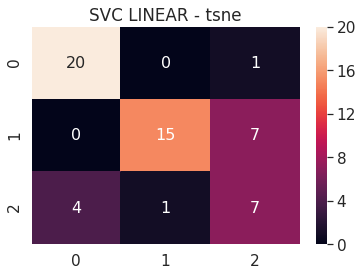

In [47]:
# SVC LINEAR TSNE 2D
tsne_2d_svc_linear = build_svm(model_type=SVM_MODELS.LINEAR_SVC, x=tsne_2d_x_train, y=tsne_2d_y_train,
                           max_iter=200000, path='models/tsne_2d_', multi_class='ovr')
print('tsne 2D - SVC LINEAR - Test accuracy', tsne_2d_svc_linear.score(tsne_2d_x_test, tsne_2d_y_test))
cm = confusion_matrix(tsne_2d_svc_linear.predict(tsne_2d_x_test), tsne_2d_y_test)
df_cm = pd.DataFrame(cm, range(n_classes), range(n_classes))
sns.set(font_scale=1.4) 
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16})
plt.title('SVC LINEAR - tsne')
plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


tsne 3D - SVC LINEAR - Test accuracy 0.8727272727272727


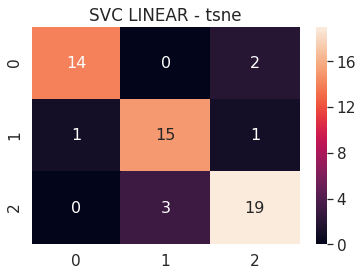

In [48]:
# SVC LINEAR TSNE 3D
tsne_3d_svc_linear = build_svm(model_type=SVM_MODELS.LINEAR_SVC, x=tsne_3d_x_train, y=tsne_3d_y_train,
                           max_iter=200000, path='models/tsne_3d_', multi_class='ovr')
print('tsne 3D - SVC LINEAR - Test accuracy', tsne_3d_svc_linear.score(tsne_3d_x_test, tsne_3d_y_test))
cm = confusion_matrix(tsne_3d_svc_linear.predict(tsne_3d_x_test), tsne_3d_y_test)
df_cm = pd.DataFrame(cm, range(n_classes), range(n_classes))
sns.set(font_scale=1.4) 
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16})
plt.title('SVC LINEAR - tsne')
plt.show()

tsne 2D - SVC RBF - Test accuracy 0.9272727272727272


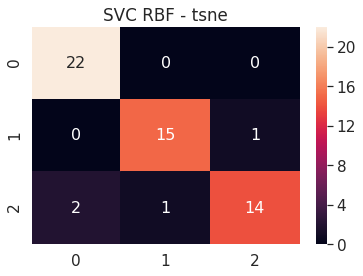

In [49]:
# SVC RBF tsne 2D
tsne_2d_svc_rbf = build_svm(model_type=SVM_MODELS.SVC, x=tsne_2d_x_train, y=tsne_2d_y_train,
                        path='models/tsne_2d_', svc_kernel='rbf')

print('tsne 2D - SVC RBF - Test accuracy', tsne_2d_svc_rbf.score(tsne_2d_x_test, tsne_2d_y_test))
cm = confusion_matrix(tsne_2d_svc_rbf.predict(tsne_2d_x_test), tsne_2d_y_test)
df_cm = pd.DataFrame(cm, range(n_classes), range(n_classes))
sns.set(font_scale=1.4) 
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16})
plt.title('SVC RBF - tsne')
plt.show()

tsne 3D - SVC RBF - Test accuracy 0.8909090909090909


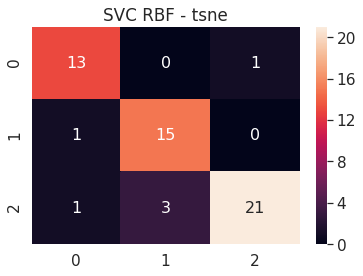

In [50]:
# SVC RBF tsne 3D
tsne_3d_svc_rbf = build_svm(model_type=SVM_MODELS.SVC, x=tsne_3d_x_train, y=tsne_3d_y_train,
                        path='models/tsne_3d_', svc_kernel='rbf')

print('tsne 3D - SVC RBF - Test accuracy', tsne_3d_svc_rbf.score(tsne_3d_x_test, tsne_3d_y_test))
cm = confusion_matrix(tsne_3d_svc_rbf.predict(tsne_3d_x_test), tsne_3d_y_test)
df_cm = pd.DataFrame(cm, range(n_classes), range(n_classes))
sns.set(font_scale=1.4) 
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16})
plt.title('SVC RBF - tsne')
plt.show()

In [27]:
def fc(input_shape, n_classes, print_summary=True):
    inputs = Input(shape=input_shape)
    x = Flatten(name='flatten')(inputs)
    x = Dense(64, activation='relu', name='fc1')(x)
    x = Dense(64, activation='relu', name='fc2')(x)
    x = Dense(n_classes, activation='softmax', name='predictions')(x)
    model = Model(inputs=inputs, outputs=x)
    if print_summary:
        model.summary()
    return model

fc_model = fc(features.shape[1:], n_classes)
fc_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

import os
def prepare_directory(model_type='vgg19'):
    save_dir = os.path.join(os.getcwd(), 'models')
    model_name = '%s_model.{epoch:03d}.h5' % model_type
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    filepath = os.path.join(save_dir, model_name)
    return filepath

filepath = prepare_directory()
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_acc', verbose=0, save_best_only=True)
callbacks = [checkpoint]

fc_model.fit(features, y, 
          validation_split=0.1, epochs=50, 
          verbose=1, workers=1, callbacks=callbacks)
score = fc_model.evaluate(features, y, batch_size=64)
print(fc_model.metrics_names)
print(score)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 7, 7, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 64)                1605696   
_________________________________________________________________
fc2 (Dense)                  (None, 64)                4160      
_________________________________________________________________
predictions (Dense)          (None, 3)                 195       
Total params: 1,610,051
Trainable params: 1,610,051
Non-trainable params: 0
_________________________________________________________________
Train on 486 samples, validate on 55 samples
Epoch 1/50
486/486 [==============================] - 1s 1ms/step - lo

31/31 [==============================] - 0s 252us/step
VGG 19 - FC - Test accuracy 1.0


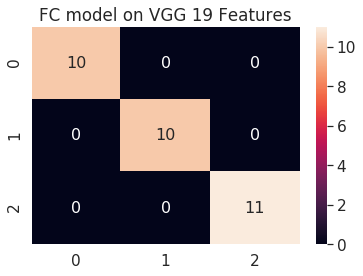

In [54]:
print('VGG 19 - FC - Test accuracy', fc_model.evaluate(features_test, y_test, batch_size)[1])
cm = confusion_matrix(np.argmax(fc_model.predict(features_test), axis=1), np.argmax(y_test, axis=1))
df_cm = pd.DataFrame(cm, range(n_classes), range(n_classes))
sns.set(font_scale=1.4) 
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16})
plt.title('FC model on VGG 19 Features')
plt.show()